# Detecting Cancer Metastases on Gigapixel Pathology Images

In [1]:
import tensorflow as tf
from tensorflow import keras

2024-05-27 10:54:48.153326: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow_datasets as tfds

In [3]:
import os
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential

In [10]:
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    "patch_camelyon",
    split = ["train", "validation", "test"], 
    shuffle_files = True,
    as_supervised = True,
    with_info = True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/32768 [00:00<?, ? examples/s]

Shuffling /Users/macbook/tensorflow_datasets/patch_camelyon/2.0.0.incompleteDCQTZK/patch_camelyon-test.tfrecor…

Generating train examples...:   0%|          | 0/262144 [00:00<?, ? examples/s]

Shuffling /Users/macbook/tensorflow_datasets/patch_camelyon/2.0.0.incompleteDCQTZK/patch_camelyon-train.tfreco…

Generating validation examples...:   0%|          | 0/32768 [00:00<?, ? examples/s]

Shuffling /Users/macbook/tensorflow_datasets/patch_camelyon/2.0.0.incompleteDCQTZK/patch_camelyon-validation.t…

Dataset patch_camelyon downloaded and prepared to /Users/macbook/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


In [11]:
print(ds_info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    full_name='patch_camelyon/2.0.0',
    description="""
    The PatchCamelyon benchmark is a new and challenging image classification
    dataset. It consists of 327.680 color images (96 x 96px) extracted from
    histopathologic scans of lymph node sections. Each image is annoted with a
    binary label indicating presence of metastatic tissue. PCam provides a new
    benchmark for machine learning models: bigger than CIFAR10, smaller than
    Imagenet, trainable on a single GPU.
    """,
    homepage='https://patchcamelyon.grand-challenge.org/',
    data_dir=PosixGPath('/var/folders/2k/n99mt5p119q1qb8l5r2wpjkr0000gn/T/tmpe4_sa3lttfds'),
    file_format=tfrecord,
    download_size=7.48 GiB,
    dataset_size=7.06 GiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(96, 96, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_ke

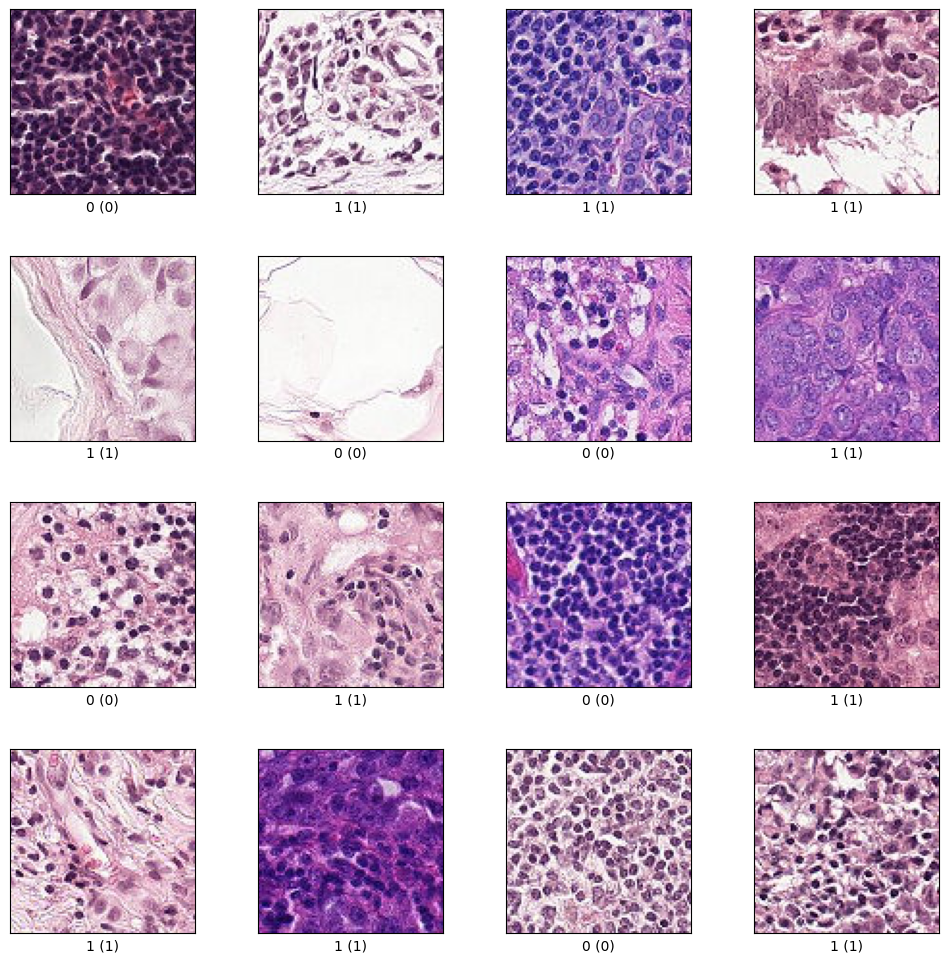

In [12]:
fig = tfds.show_examples(ds_train, ds_info, rows = 4, cols = 4)

In [13]:
def normalize_img(image, label):
  # this will normalize the images
  return tf.cast(image, tf.float16)/255.0, label

In [14]:
def augment(image_label, seed):
  image, label = image_label
  image, label = normalize_img(image, label)
  # I ended up not performing data augmentation as it decreased the accuracy of my model.
  return image, label

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# When choosing the number of parallel calls for next step, TensorFlow can decide the best value to optimize productivity. 
BATCH_SIZE = 16

In [16]:
counter = tf.data.experimental.Counter()
ds_train = tf.data.Dataset.zip((ds_train, (counter, counter)))

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


In [17]:
ds_train = ds_train.map(augment, num_parallel_calls = AUTOTUNE)
ds_train = ds_train.cache()
# This will allow some of the data to be kept in memory so it will be loaded more quickly next time
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
# Shuffles data randomly
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)
# Helps increase efficiency, will prepare some examples while the GPU is running

In [18]:
ds_validation = ds_validation.map(normalize_img, num_parallel_calls = AUTOTUNE)
ds_validation = ds_validation.batch(32)
ds_validation = ds_validation.prefetch(AUTOTUNE)

In [19]:
ds_test = ds_test.map(normalize_img, num_parallel_calls = AUTOTUNE)
ds_test = ds_test.batch(32)
ds_test = ds_test.prefetch(AUTOTUNE)

In [20]:
def create_model(image_size = 96):
  inception = InceptionV3(weights = 'imagenet',
                          include_top = False,
                          input_shape = (image_size, image_size, 3))
  
  for layer in inception.layers:
    layer.trainable = False

  model = Sequential()
  model.add(inception)
  model.add(GlobalAveragePooling2D())

  input = Input(shape=(image_size, image_size, 3))

  encoded = model(input)

  dense1 = Dense(256, activation='relu')(encoded)
  batch_normalization1 = BatchNormalization()(dense1)
  drop_layer = tf.keras.layers.Dropout(0.7)(batch_normalization1)
  dense2 = Dense(128, activation='relu')(drop_layer)
  batch_normalization2 = BatchNormalization()(dense2)
  drop_layer2 = tf.keras.layers.Dropout(0.7)(batch_normalization2)

  output = Dense(1, activation='sigmoid')(drop_layer2)
  model = Model(inputs=[input], outputs=output)

  return model

In [26]:
model = create_model()
# model.summary()

87910968/87910968 [==============================] - 15s 0us/step


In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization_564 (B  (None, 256)               1024      
 atchNormalization)                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                             

In [28]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [29]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss" , patience=5 , verbose=1)]

In [30]:
model.fit(ds_train,
          batch_size = 16, 
          epochs = 20,
          verbose=1,
          validation_data = (ds_validation),
          callbacks = callbacks
          )

Epoch 1/20


2024-05-27 15:59:33.281932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:210: Filling up shuffle buffer (this may take a while): 26440 of 262144
2024-05-27 15:59:43.285932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:210: Filling up shuffle buffer (this may take a while): 50838 of 262144
2024-05-27 16:00:03.281872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:210: Filling up shuffle buffer (this may take a while): 94208 of 262144
2024-05-27 16:00:13.303001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:210: Filling up shuffle buffer (this may take a while): 117118 of 262144
2024-05-27 16:00:33.282124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:210: Filling up shuffle buffer (this may take a while): 164835 of 262144
2024-05-27 16:00:53.281852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:210: Filling up shuf

16384/16384 [==============================] - 3292s 194ms/step - loss: 0.5690 - accuracy: 0.7255 - val_loss: 0.4667 - val_accuracy: 0.7788
Epoch 2/20
16384/16384 [==============================] - 2447s 149ms/step - loss: 0.4930 - accuracy: 0.7685 - val_loss: 0.4493 - val_accuracy: 0.7847
Epoch 3/20
16384/16384 [==============================] - 2322s 142ms/step - loss: 0.4791 - accuracy: 0.7775 - val_loss: 0.4430 - val_accuracy: 0.7888
Epoch 4/20
16384/16384 [==============================] - 2374s 145ms/step - loss: 0.4700 - accuracy: 0.7824 - val_loss: 0.4375 - val_accuracy: 0.7910
Epoch 5/20
16384/16384 [==============================] - 2365s 144ms/step - loss: 0.4641 - accuracy: 0.7859 - val_loss: 0.4376 - val_accuracy: 0.7896
Epoch 6/20
16384/16384 [==============================] - 3139s 192ms/step - loss: 0.4603 - accuracy: 0.7884 - val_loss: 0.4326 - val_accuracy: 0.7930
Epoch 7/20
16384/16384 [==============================] - 3463s 211ms/step - loss: 0.4548 - accuracy: 0.7

In [31]:
model.evaluate(ds_test)

1024/1024 [==============================] - 319s 311ms/step - loss: 0.4322 - accuracy: 0.8004


[0.4322079122066498, 0.800445556640625]

In [32]:
# serialize model to JSON
model_json = model.to_json()
with open("model-cancer-local.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model-cancer-local.h5")
print("Saved model to disk")

Saved model to disk


In [33]:
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open('model-cancer-local.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model-cancer-local.h5")
print("Loaded model from disk")
 

Loaded model from disk


In [34]:
loaded_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [35]:
loaded_model.evaluate(ds_test)

1024/1024 [==============================] - 305s 295ms/step - loss: 0.4322 - accuracy: 0.8004


[0.43220779299736023, 0.800445556640625]